**Question**: GPS and other camera information are encoded in exif tags. Can this data be used to determine characteristics such as leaf size? Can other data, such as soil maps, weather, etc. be used to find correlations among phenotypes?

In [1]:
import cv2
import exif
import random
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

Load the data

In [2]:
HOME_DIR = str(Path().cwd().parent)
matplotlib.rcParams["figure.dpi"] = 600

SHEET_DATA = pd.read_excel(f"{HOME_DIR}/step3/data.xlsx")
SHEET_DATA.tail()

,filename,treatment,block,row,position,genotype,leaf_color,leaf_shape,brown_splotches
1667,91F395A8-E156-416C-84E8-A2880F067945.jpg,D*,NaN,NaN,NaN,NaN,dark_green,lanceolate,low
1668,18E8E0DC-35EE-4C34-839A-71E0E6D7F3AD.jpg,C,1.0,12.0,27.0,GW-6962_WP,yellow_green,lanceolate,low
1669,DB2D48CC-17CD-4A96-BC52-CFFC5879641B.jpg,C,2.0,5.0,49.0,GW-9784_LM,light_green,lanceolate,none
1670,2258AE77-D53C-446F-8DAD-0E948854EBDC.jpg,C,2.0,42.0,43.0,"**GW-4579_WP**,core",dark_green,lanceolate,low
1671,5FCC7048-CC04-40DA-B3DB-F6404CA41931.jpg,C,2.0,38.0,31.0,BESC-217_LM,dark_green,elliptical,high


Function and type declarations

In [3]:
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

Get the EXIF tags from the image

In [4]:
def get_lat_long(filename: str) -> tuple:
    with open(f"{HOME_DIR}/dataset/{filename}", "rb") as f:
        exifs = exif.Image(f)
    lat = np.array(exifs.gps_latitude) * ((exifs.gps_latitude_ref == 'N') * 2 - 1)
    long = np.array(exifs.gps_longitude) * ((exifs.gps_longitude_ref == 'E') * 2 - 1)
    return (tuple(lat), tuple(long))

def get_date(filename: str) -> datetime:
    with open(f"{HOME_DIR}/dataset/{filename}", "rb") as f:
        exifs = exif.Image(f)
    return datetime(*map(int, exifs.gps_datestamp.split('-')))

filename = get_random_filename()
print(get_lat_long(filename))
print(get_date(filename))

((38.0, 32.0, 28.2404), (-121.0, -47.0, -23.9523))
2021-09-01 00:00:00


#### Visualize unique dates and locations

In [5]:
locations, dates = [], []
for filename in SHEET_DATA['filename']:

    dates.append(get_date(filename))
    locations.append(get_lat_long(filename))

Unique dates

In [6]:
set(dates)

{datetime.datetime(2021, 8, 30, 0, 0),
 datetime.datetime(2021, 8, 31, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 9, 2, 0, 0),
 datetime.datetime(2021, 9, 3, 0, 0)}

Unique approximate locations

In [7]:
{*map(lambda x: tuple(map(lambda y: y[:2], x)), locations)}

{((38.0, 32.0), (-121.0, -47.0))}

#### NOTE: THE ANALYSIS BELOW IS NOT IN THE PAPER, IT WAS DONE AFTER SUBMISSION

Location by row? to physical traits

In [8]:
data = []
target_correlation = "treatment"
is_nan = lambda x: str(x) == 'nan' or (x > 1000 if isinstance(x, float) else False)
for i in range(len(SHEET_DATA)):
    x, y = get_lat_long(SHEET_DATA["filename"][i])
    t = SHEET_DATA[target_correlation][i]
    if all(not is_nan(i) for i in [x, y, t]):
        data.append({
            target_correlation: t,
            "x": x[2],
            "y": y[2]
        })

Plot data

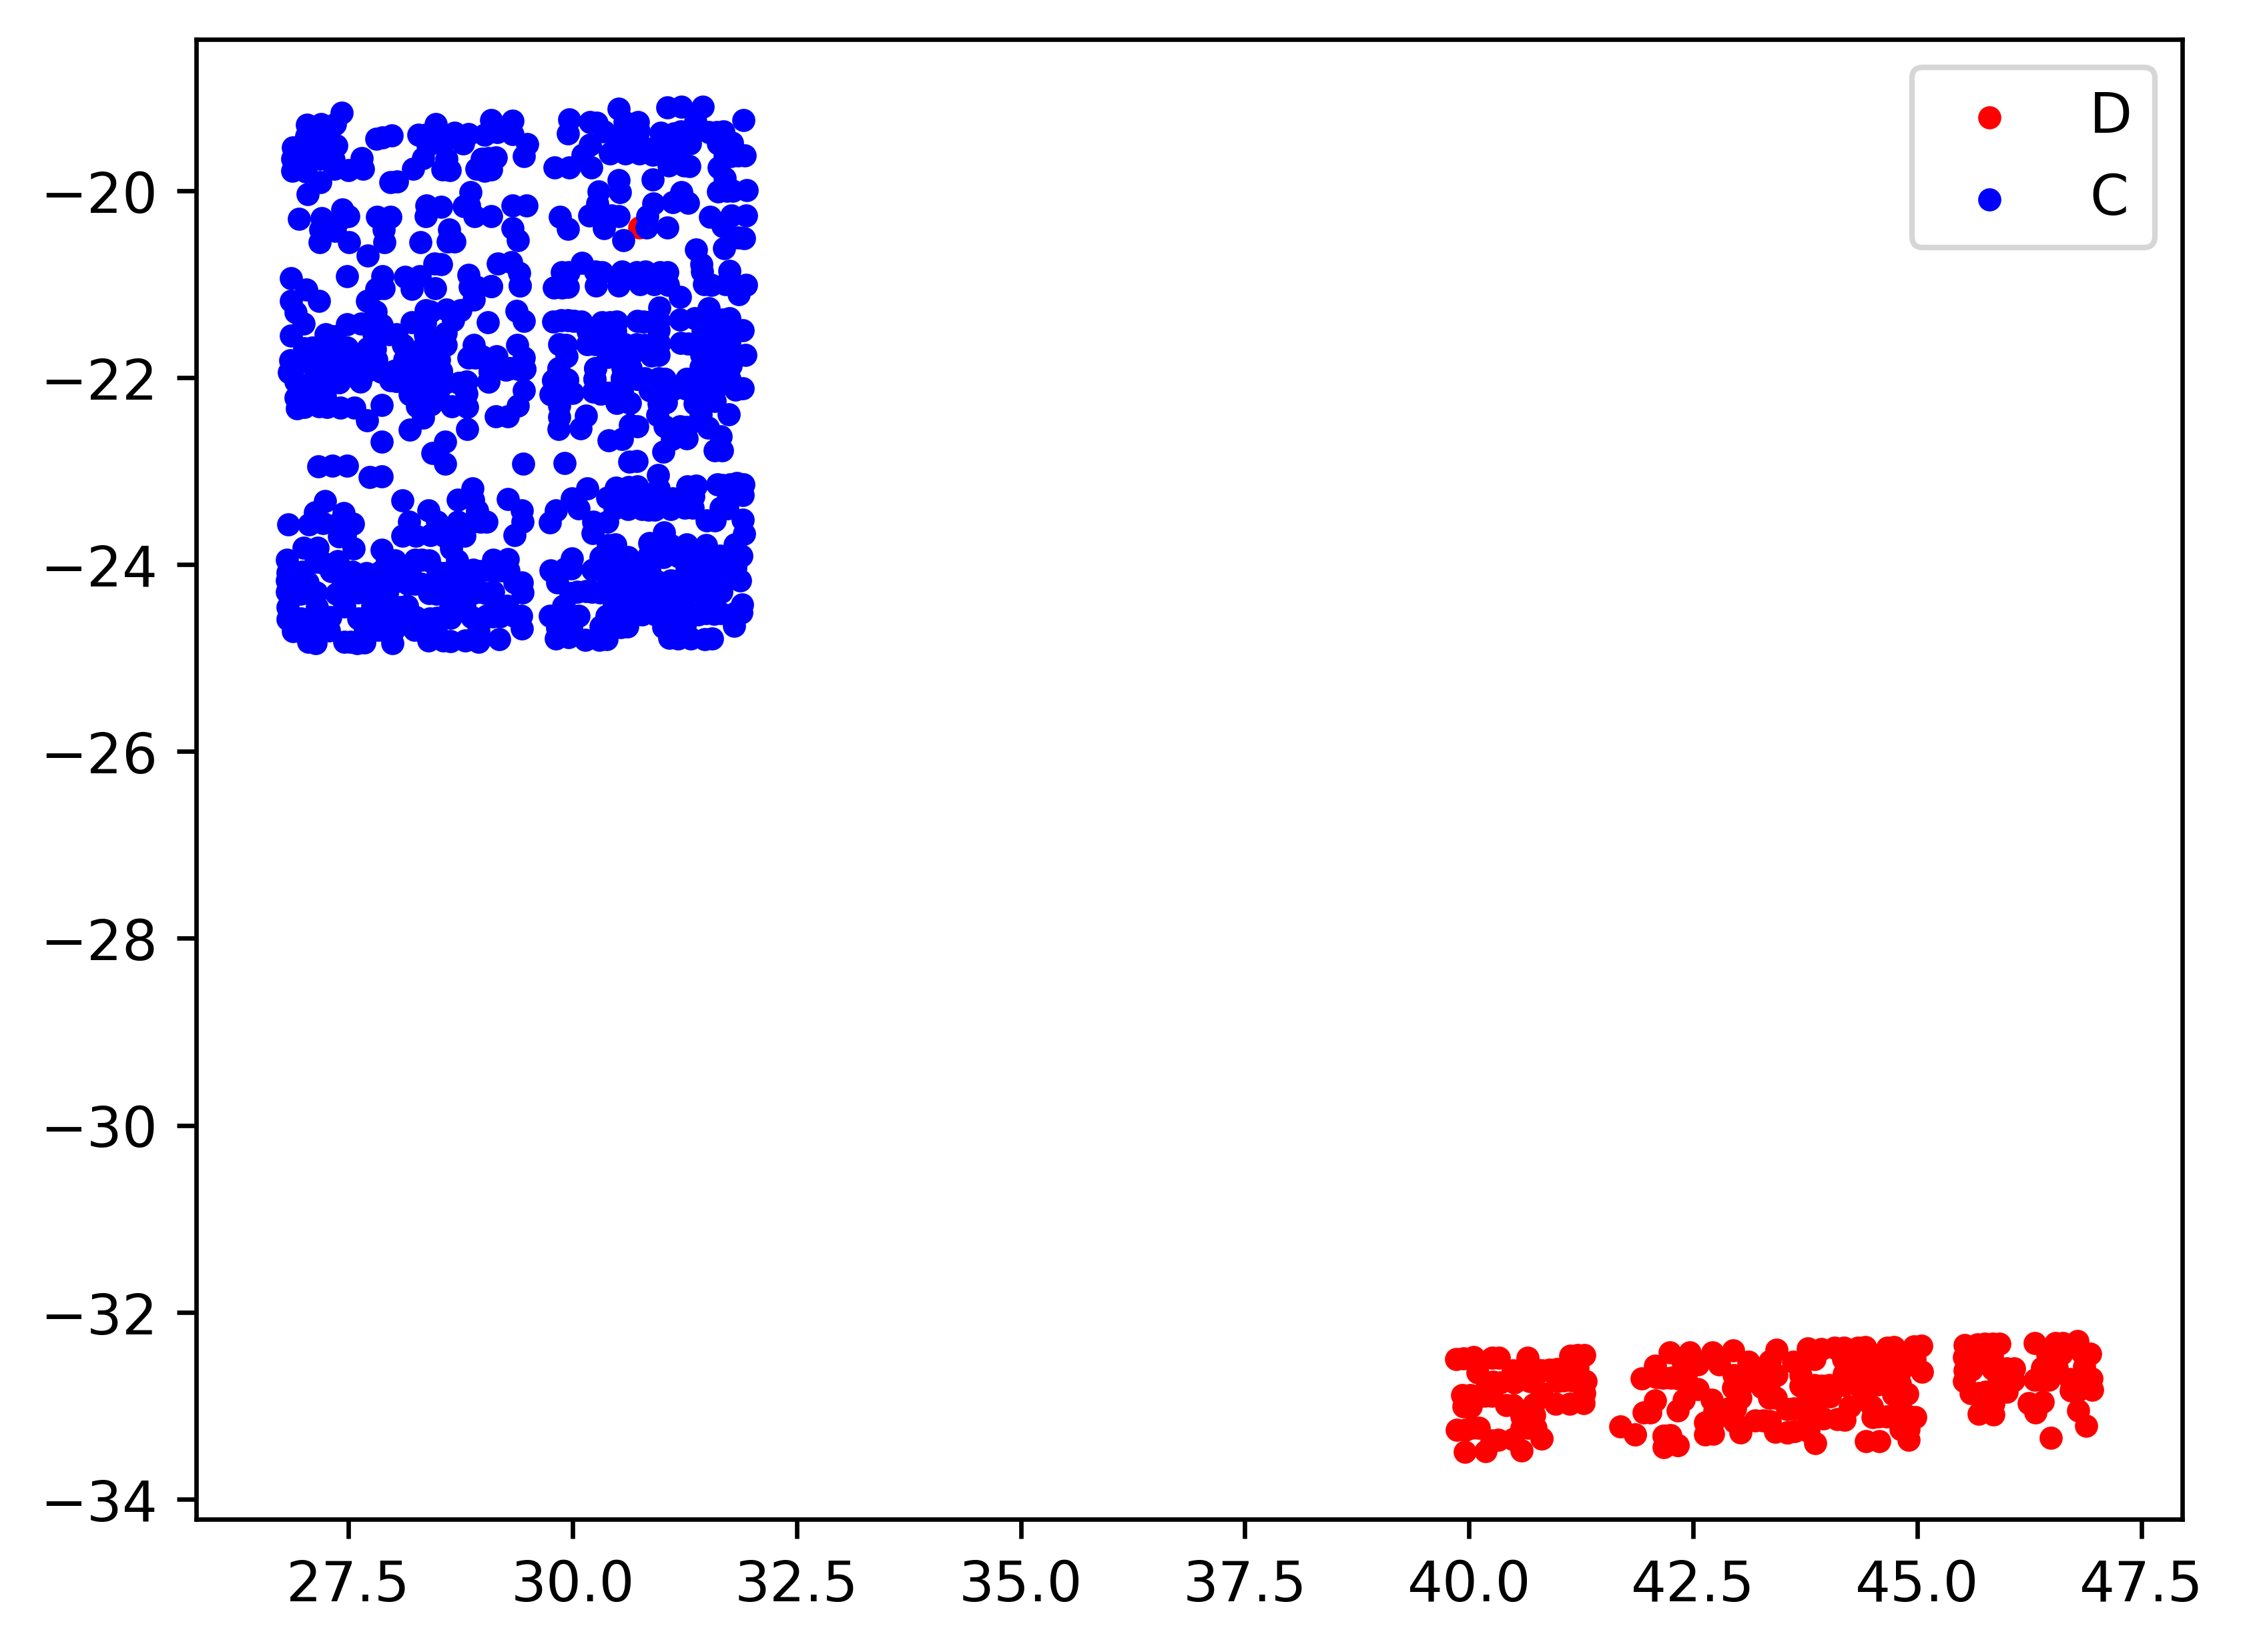

In [9]:
different_classes = {}
for row in data:
    t = row[target_correlation]
    if not different_classes.get(t):
        different_classes[t] = {'x': [], 'y': []}
    different_classes[t]['x'].append(row['x'])
    different_classes[t]['y'].append(row['y'])

del different_classes["C*"] 
del different_classes["D*"]

for (cls, d), color in zip(different_classes.items(), ['red', 'blue', 'green', 'magenta', 'orange']):
    plt.scatter(d['x'], d['y'], color=color, label=cls, s=10)
plt.legend(loc="best")
plt.show()

It can be seen that there are specific rows given the drought label. However, there is not much else that can be found.